<a href="https://colab.research.google.com/github/ctwardy/fastai_bayesian/blob/master/Bayesian_NN_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Bayesian Neural Networks with Fastai by Daniel Huynh

This notebook will explore a few datasets and show how one can quickly leverage uncertainty estimates from existing models by simply using MC Dropout.

**Minor Changes by CRT**:
* Use `sns.histplot` instead of deprecated `sns.distplot`.
* Suppress Torch warnings to FastAI
* Shorten some functions by better choice of defaults. 
* Only 3 sigdigits.



## Helper functions

Here we will define a few functions to make it easier for us to use Dropout for inference.

### Custom Dropout

We create a class CustomDropout, because when we put a model on eval mode in Pytorch, Dropout is deactivated and we do not want to stop the stochasticity during inference to use MC Dropout. Therefore we create our own modified version of Dropout which has a different switch to turn on or off the randomness.

We then create a function which will automaticlly switch the CustomDropouts to False or True.

Finally, we create a function that will replace all nn.Dropout to CustomDropout. 

In [1]:
import torch.nn as nn
import torch
from fastai.basic_train import DatasetType
from typing import Callable

class CustomDropout(nn.Module):
    """Custom Dropout module to be used as a baseline for MC Dropout"""

    def __init__(self, p:float, activate=True):
        super().__init__()
        self.activate = activate
        self.p = p

    def forward(self, x):
        return nn.functional.dropout(x, self.p, training=self.training or self.activate)

    def extra_repr(self):
        return f"p={self.p}, activate={self.activate}"


def switch_custom_dropout(m, activate:bool=True, verbose:bool=False):
    """Turn all Custom Dropouts training mode to true or false according to the variable activate"""
    for c in m.children():
        if isinstance(c, CustomDropout):
            print(f"Current active : {c.activate}")
            print(f"Switching to : {activate}")
            c.activate = activate
        else:
            switch_custom_dropout(c, activate=activate) 

def convert_layers(model:nn.Module, original:nn.Module, 
                   replacement:nn.Module, get_args:Callable=lambda x:{},
                   additional_args:dict={}):
    """Convert modules of type "original" to "replacement" inside the model
    
    get_args : a function to use on the original module to eventually get its arguements to pass to the new module
    additional_args : a dictionary to add more args to the new module
    """
    for child_name, child in model.named_children():
        if isinstance(child, original):
            args = {**get_args(child), **additional_args} 
            new_layer = replacement(**args)
            setattr(model, child_name, new_layer)
        else:
            convert_layers(child, original, replacement,
                           get_args, additional_args)         

### Metrics

When using MC Dropout, we will sample $T$ different models, and compute statistics from this, for instance prediction will be just the average prediction of all models.

Moreover, we can also get uncertainty metrics using those $T$ different outputs.

For regression, the most simple metric is variance of the predictions :
$$V = \frac{1}{T} \sum_{t=1}^{T} \hat{y_t}^2 - (\frac{1}{T} \sum_{t=1}^{T} \hat{y_t})^2$$

with $\hat{y_t}$ the scalar output of the $t$-th sample. 

For classification, if we have $C$ classes, we can use entropy in the following way : 

$$\hat{y_c} = \frac{1}{T} \sum_{t=1}^{T} \hat{y_{c,t}}$$
$$H = - \frac{1}{C} \sum_{c=1}^{C} \hat{y_c} log(\hat{y_c})$$

<center>with $\hat{y_{c,t}}$ the probability of class $c$ of the $t$-th sample.</center>

Dividing by $C$ gives the _average_ entropy instead of the _total_.  The original code just used the total.  Because $C$ is always the same, it's irrelevant to optimization, and dividing hastens underflow, but here I've added that step.

In [2]:
from fastai.basic_train import DatasetType
from fastai.torch_core import to_np
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def entropy(probs, softmax=False):
    """Return the entropy of prediction of a T*N*C tensor with :
        - T : the number of samples
        - N : the batch size
        - C : the number of classes

    Note: Return *total* entropy. To get avg, uncomment division.
    
    """
    probs = to_np(probs)     # Appears unneeded;
    prob = probs.mean(axis=0)  # Avg over samples
    entrop = - (np.log(prob) * prob).sum(axis=1) #/ prob.size(axis=1)
    return entrop


def uncertainty_best_probability(probs):
    """Return the standard deviation of the most probable class"""
    idx = probs.mean(axis=0).argmax(axis=1)

    std = probs[:, np.arange(len(idx)), idx].std(axis=0)

    return std


def BALD(probs):
    """Information Gain, distance between the entropy of averages and average of entropy"""
    entrop1 = entropy(probs)
    probs = to_np(probs)

    entrop2 = - (np.log(probs) * probs).sum(axis=2)
    entrop2 = entrop2.mean(axis=0)

    ig = entrop1 - entrop2
    return ig


def top_k_uncertainty(s, k=5, reverse=True):
    """Return the top k indexes"""
    sorted_s = sorted(list(zip(np.arange(len(s)), s)),
                      key=lambda x: x[1], reverse=reverse)
    output = [sorted_s[i][0] for i in range(k)]
    return output


def get_preds_sample(learn, ds_type=DatasetType.Valid, n_sample=10, reduce=None,activ=None,with_loss=False):
    """Get MC Dropout predictions from a learner, and eventually reduce the samples"""
    preds = []
    for i in range(n_sample):
        pred, y = learn.get_preds(ds_type=ds_type,activ=activ)
        pred = pred.view((1,) + pred.shape)
        preds.append(pred)
    preds = torch.cat(preds)
    if reduce == "mean":
        preds = preds.mean(dim=0)
    return preds, y

def plot_hist_groups(pred,y,metric,bins=None,figsize=(16,16)):
    TP = to_np((pred.mean(dim=0).argmax(dim=1) == y) & (y == 1))
    TN = to_np((pred.mean(dim=0).argmax(dim=1) == y) & (y == 0))
    FP = to_np((pred.mean(dim=0).argmax(dim=1) != y) & (y == 0))
    FN = to_np((pred.mean(dim=0).argmax(dim=1) != y) & (y == 1))
    
    result = metric(pred)
    
    TP_result = result[TP]
    TN_result = result[TN]
    FP_result = result[FP]
    FN_result = result[FN]
    
    fig,ax = plt.subplots(2,2,figsize=figsize)
    
    sns.histplot(TP_result,ax=ax[0,0],bins=bins, kde=True, ec=None)
    ax[0,0].set_title(f"True positive")
    
    sns.histplot(TN_result,ax=ax[0,1],bins=bins, kde=True, ec=None)
    ax[0,1].set_title(f"True negative")
    
    sns.histplot(FP_result,ax=ax[1,0],bins=bins, kde=True, ec=None)
    ax[1,0].set_title(f"False positive")
    
    sns.histplot(FN_result,ax=ax[1,1],bins=bins, kde=True, ec=None)
    ax[1,1].set_title(f"False negative")

## Examples with Fastai

### Image dataset with Cats and Dogs

In [3]:
from fastai.vision import *

path = untar_data(URLs.PETS)

In [4]:
images = path/"images"
fnames = get_image_files(images)

Ignore warnings to FastAI about changes in Torch default behaviors.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [6]:
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)
np.random.seed(42)

data = ImageDataBunch.from_name_re(images, fnames, pat, ds_tfms=get_transforms(),
                                   size=224).normalize(imagenet_stats)

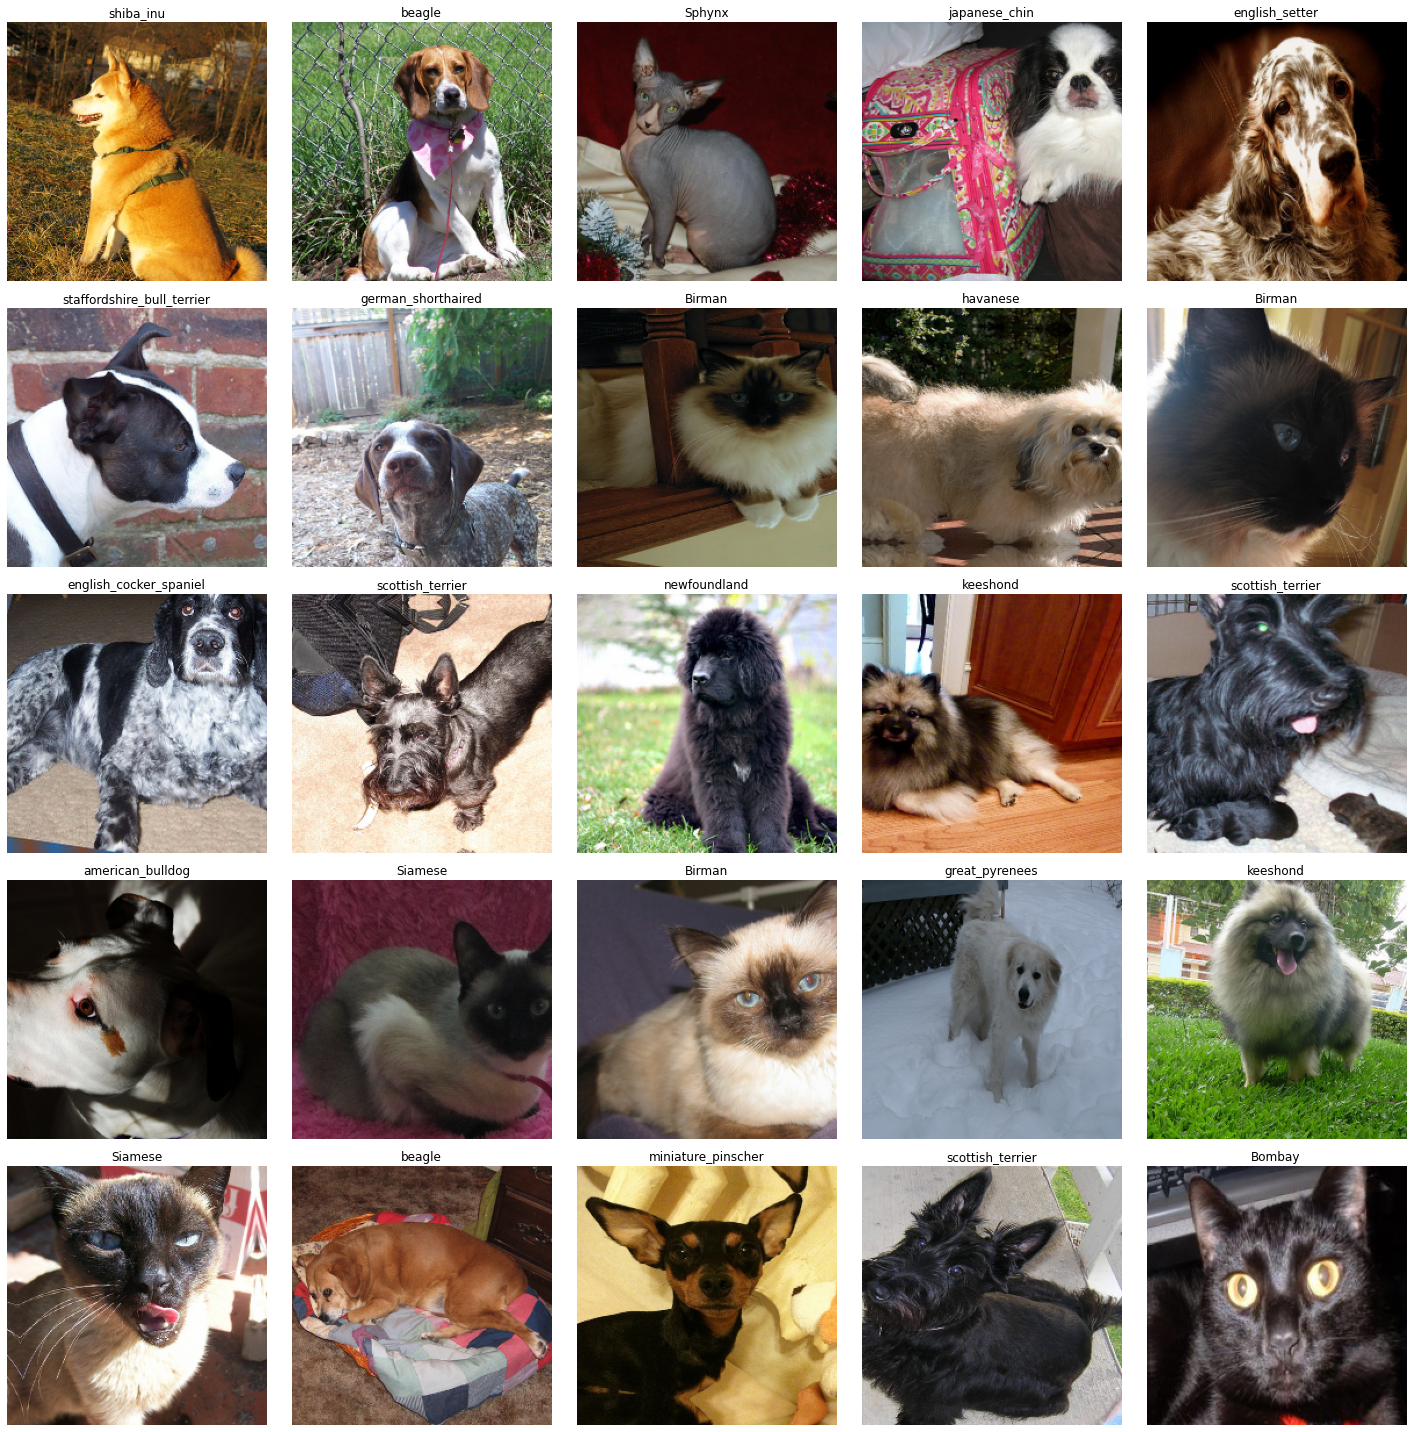

In [7]:
data.show_batch()

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


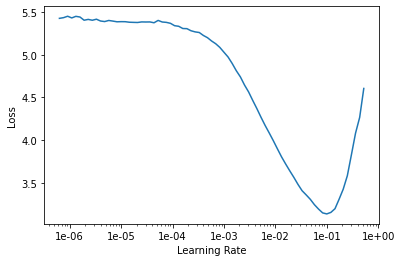

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(4,1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


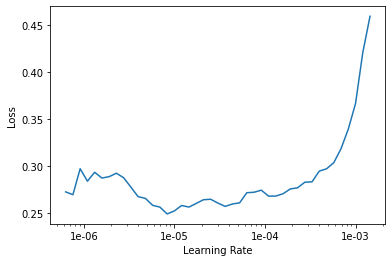

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2,1e-5)

In [13]:
# Convert nn.Dropout to CustomDropout module
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model, nn.Dropout, CustomDropout, get_args)

# Turn on the stochasticity, I use verbose just to make sure it's working fine
switch_custom_dropout(learn.model, True, verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True


In [14]:
def predict_entropy(img, n_times=10):
    pred = learn.predict_with_mc_dropout(img, n_times=n_times)
    probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
    probs = torch.cat(probs)
    e = entropy(probs)
    return e
  
def plot_img_with_entropy(img, n_times=10):
    e = predict_entropy(img, n_times=n_times)
    img = to_np(img.data.permute(1,2,0))
    plt.imshow(img)
    plt.title(f"Entropy : {e[0]:.3f}")

Get a non-cat image.

In [15]:
!wget https://wikiofthrones.com/static/uploads/2017/08/night-king-compressed.jpg

--2021-06-29 20:03:31--  https://wikiofthrones.com/static/uploads/2017/08/night-king-compressed.jpg
Resolving wikiofthrones.com (wikiofthrones.com)... 104.21.54.112, 172.67.138.55, 2606:4700:3031::6815:3670, ...
Connecting to wikiofthrones.com (wikiofthrones.com)|104.21.54.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48737 (48K) [image/jpeg]
Saving to: ‘night-king-compressed.jpg’

night-king-compress 100%[===================>]  47.59K  --.-KB/s    in 0.007s  

2021-06-29 20:03:31 (6.30 MB/s) - ‘night-king-compressed.jpg’ saved [48737/48737]



In [16]:
img = open_image("night-king-compressed.jpg")

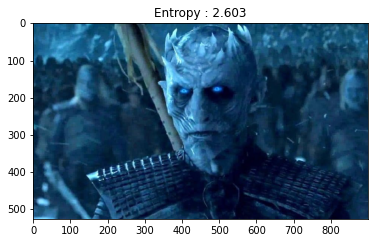

In [17]:
plot_img_with_entropy(img)

In [18]:
pred = learn.predict_with_mc_dropout(img, n_times=10)
probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
probs = torch.cat(probs)
print(f"Highest class has probability : {probs.mean(dim=0).squeeze(0).max():.3f}")

Highest class has probability : 0.207


Get a cat

In [19]:
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2021-06-29 20:03:32--  https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png
Resolving icatcare.org (icatcare.org)... 142.93.47.206
Connecting to icatcare.org (icatcare.org)|142.93.47.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246129 (1.2M) [image/png]
Saving to: ‘Thinking-of-getting-a-cat.png’

Thinking-of-getting 100%[===================>]   1.19M  1.53MB/s    in 0.8s    

2021-06-29 20:03:33 (1.53 MB/s) - ‘Thinking-of-getting-a-cat.png’ saved [1246129/1246129]



In [20]:
img = open_image("Thinking-of-getting-a-cat.png")

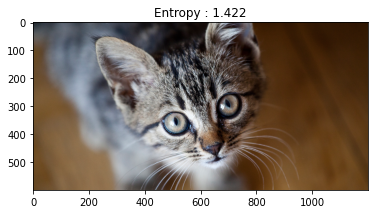

In [21]:
plot_img_with_entropy(img)

This seems to require the `to_np()` calls in the helper functions. Else entropy looks like night king's entropy.  Why? Or was it another change, like the recursion order?

In [22]:
pred = learn.predict_with_mc_dropout(img, n_times=10)
probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
probs = torch.cat(probs)
print(f"Highest class has probability : {probs.mean(dim=0).squeeze(0).max():.3f}")

Highest class has probability : 0.405


In [23]:
preds,y = get_preds_sample(learn)

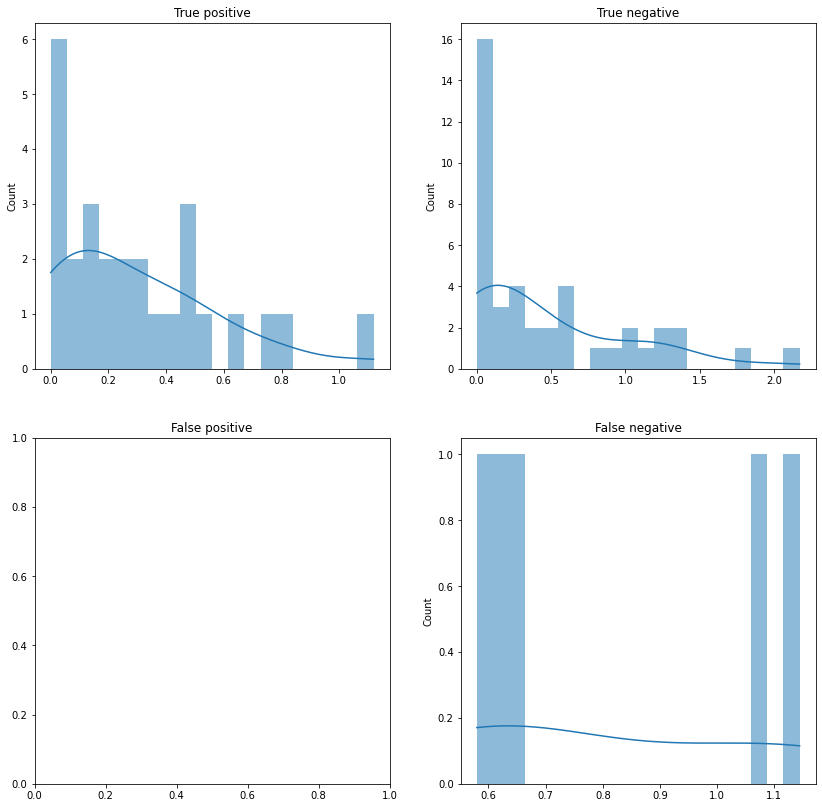

In [24]:
plot_hist_groups(preds, y, entropy, bins=20, figsize=(14,14))

### Text dataset with IMDB

In [25]:
from fastai.text import * 

path = untar_data(URLs.IMDB_SAMPLE)

df = pd.read_csv(path/'texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [26]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

In [27]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

In [28]:
learn.save_encoder('ft_enc')

In [29]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos xxmaj the movie is great and i like the story . i prefer this movie than other movie such xxmaj the cell ( sick movie ) and xxmaj xxunk ( silly movie ) . i just tell the truth , i like a reality xxunk and also a true story :) 
 
 ,xxbos xxmaj though i liked xxmaj on the xxmaj town better i really liked it . i 'm a new xxunk when it comes to xxmaj frank xxmaj sinatra and xxmaj gene xxmaj kelly . xxmaj though i had heard of them i had never seen anything with them in it until recently . xxmaj the first one i saw was xxmaj xxunk in the xxmaj rain that made me a fan of xxmaj gene 's . i think that is better too . xxmaj but i thought that this movie was good and like all movies there are some parts that are better than others but in my book it 's an awesome movie and i love it . xxmaj frank and xxmaj gene make a good team . i have yet to see them together in xxmaj take me out to the xxmaj xxunk . xxmaj but i 

In [30]:
learn.fit_one_cycle(1, 1e-2)

In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

In [32]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

In [33]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True


In [34]:
pred,y = get_preds_sample(learn)

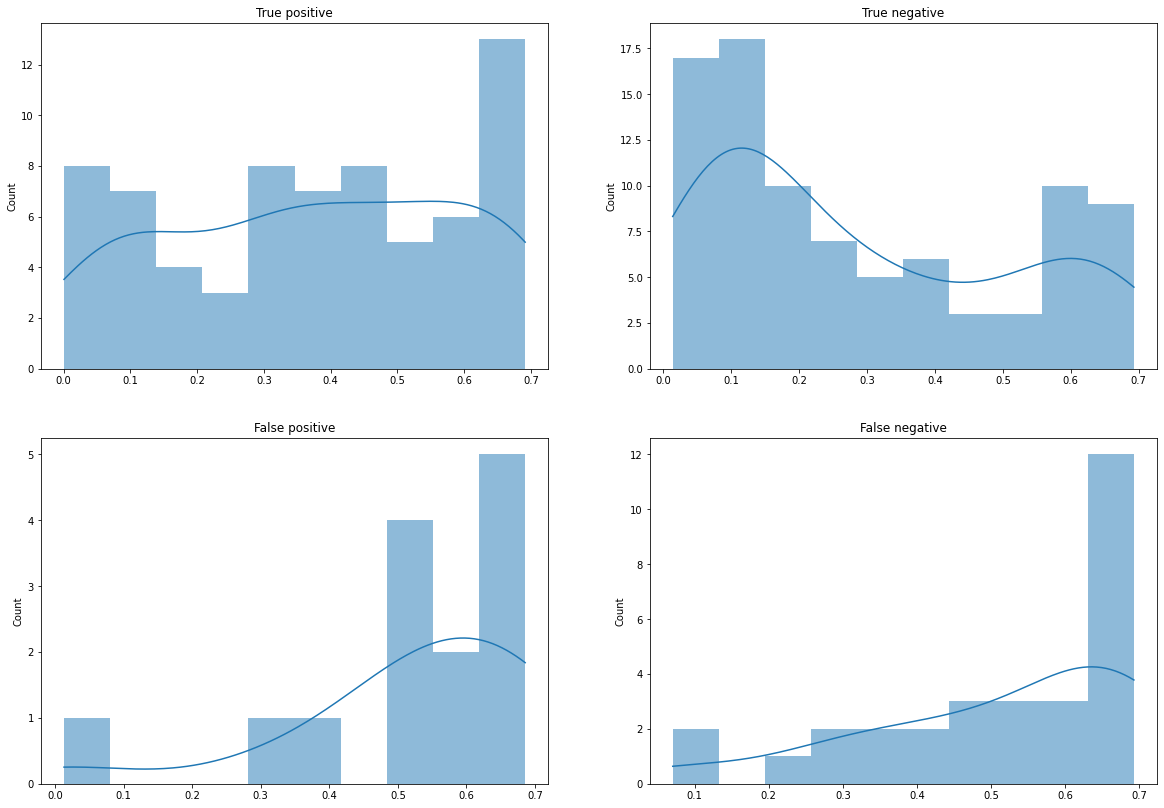

In [35]:
plot_hist_groups(pred,y,entropy,bins=10,figsize=(20,14))

In [36]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=False)
for review in learn.data.valid_ds[idx]:
    print("_____________")
    print("Review : ")
    print(review)

_____________
Review : 
(Text [   2    5   21   32 ...   12  414 2825   54], Category 1)
_____________
Review : 
(Text [   2    5   21    0 ...   66 1351   66   11], Category 0)
_____________
Review : 
(Text [  2  19 123   9 ...  42 243  21  11], Category 0)
_____________
Review : 
(Text [   2    5   21   28   16   44   14    9 4248   49    5  553    5 7822   11    5   17   16   57 2187   10 8038   10
 8039   10 5789   10    0   10 2442   10 3226   11    5   12   17   16   52  403  342   49  112    5 1812  204    0
  600   11   26], Category 1)
_____________
Review : 
(Text [  2   5  21  32 ... 455  47 125  11], Category 0)


In [37]:
idx = top_k_uncertainty(H,reverse=True)
for review in learn.data.valid_ds[idx]:
    print("_____________")
    print("Review : ")
    print(review)

_____________
Review : 
(Text [   2   19   90  499 ...   44   98 6117   11], Category 1)
_____________
Review : 
(Text [   2    5 1111   84 ...   49    7  287  176], Category 0)
_____________
Review : 
(Text [  2  13 532  14 ...  13 227  69  11], Category 1)
_____________
Review : 
(Text [  2   5  52 134 ... 154 193  68  11], Category 1)
_____________
Review : 
(Text [   2    5   29   28 ...   17  105 4135   11], Category 0)


### Tabular dataset with Adult income

In [38]:
from fastai.tabular import *

path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt  ... hours-per-week  native-country salary
0   49            Private  101320  ...             40   United-States  >=50k
1   44            Private  236746  ...             45   United-States  >=50k
2   38            Private   96185  ...             32   United-States   <50k
3   38       Self-emp-inc  112847  ...             40   United-States  >=50k
4   42   Self-emp-not-inc   82297  ...             50   United-States   <50k

[5 rows x 15 columns]

In [39]:
positive_idx = df.loc[df.salary == ">=50k"].index
negative_idx = df.loc[df.salary != ">=50k"].index

n = len(positive_idx) // 2
positive = np.random.choice(positive_idx,n,replace=False)

negative = np.random.choice(negative_idx,n,replace=False)

train_idx = np.concatenate([negative,positive])

valid_idx = df.index[~np.isin(df.index,train_idx)]

In [40]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

learn = tabular_learner(data, layers=[200,100],ps=[0.10,0.05], emb_szs={'native-country': 10}, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


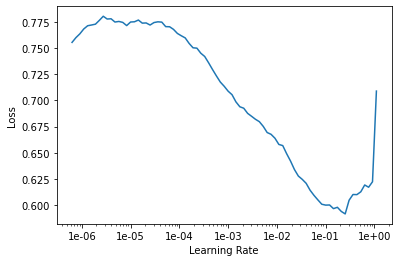

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, 1e-2)

In [43]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


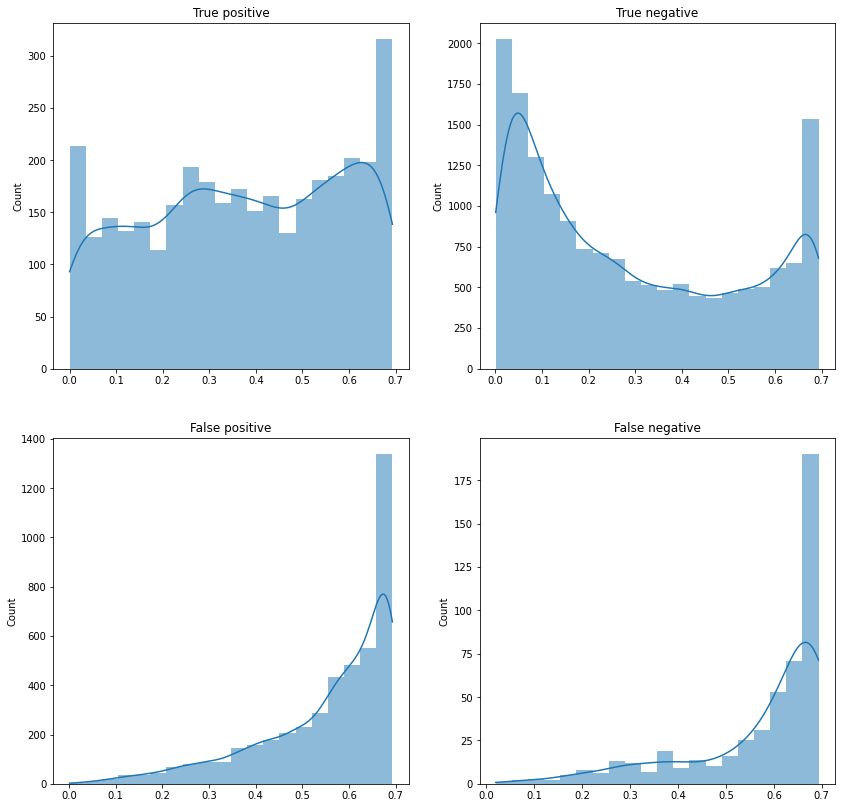

In [44]:
pred,y = get_preds_sample(learn)
plot_hist_groups(pred,y,entropy,bins=20,figsize=(14,14))

In [45]:
raw_pred,y = get_preds_sample(learn,activ= lambda x : x)

In [46]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=True,k=2)
print("Most uncertain observations")
print(learn.data.valid_ds[idx])

print("_______________")

idx = top_k_uncertainty(H,reverse=False,k=2)
print("Most certain observations")
print(learn.data.valid_ds[idx])

Most uncertain observations
LabelList (2 items)
x: TabularList
age                             1.57942
workclass              Self-emp-not-inc
fnlwgt                         0.526777
education                       HS-grad
education-num                 -0.621904
marital-status       Married-civ-spouse
occupation                 Craft-repair
relationship                    Husband
race                              White
sex                                Male
capital-gain                  -0.199568
capital-loss                  -0.262333
hours-per-week                 0.806445
native-country            United-States
salary                            >=50k
education-num_na                  False
Name: 9970, dtype: object,age                           -0.187621
workclass                       Private
fnlwgt                          2.48198
education                          12th
education-num                  -1.01278
marital-status       Married-civ-spouse
occupation                Other